In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

TensorFlow 1.x selected.


# Goal

- Download google fonts
- Produce a dataset of individual characters for each font (grouped by character)

## Past Work



### PIL image generation

From "PIL + Fonts?" section of [cairo-freetype-andrewmlook.ipynb](https://colab.research.google.com/drive/1EO9uvDS_zzhGtFeKadEj7CTlYbKki3QE?authuser=1#scrollTo=cKgA7DR-Tqqr):

> 
> http://effbot.org/imagingbook/imagefont.htm
> 
> http://effbot.org/imagingbook/
> 
> ```python
> from PIL import ImageFont, ImageDraw
> 
> draw = ImageDraw.Draw(image)
> 
> # use a bitmap font
> font = ImageFont.load("arial.pil")
> 
> draw.text((10, 10), "hello", font=font)
> 
> # use a truetype font
> font = ImageFont.truetype("arial.ttf", 15)
> 
> draw.text((10, 25), "world", font=font)
```


In [0]:
!wget -q https://github.com/rougier/freetype-py/raw/master/examples/Vera.ttf
!wget -q https://github.com/rougier/freetype-py/blob/master/examples/VeraMono.ttf
!wget -q https://github.com/rougier/freetype-py/blob/master/examples/SourceSansVariable-Roman.otf

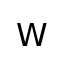

In [0]:
from PIL import ImageFont, ImageDraw, Image

im = Image.new("RGB", (64, 64), "white")
draw = ImageDraw.Draw(im)
# use a truetype font
font = ImageFont.truetype("Vera.ttf", 32)
draw.text((16, 16), "W", font=font, fill='black')

im

## Getting google fonts


- https://github.com/google/fonts

> "You can download all Google Fonts in a simple ZIP snapshot (over 300MB) from https://github.com/google/fonts/archive/master.zip"

potentially useful:


https://github.com/googlefonts/gftools/blob/master/font-metadata.csv


https://github.com/googlefonts/gf-docs/tree/master/METADATA



In [0]:
![[ -f master.zip ]] || (echo "dowloading fonts" && wget -q https://github.com/google/fonts/archive/master.zip)
!ls -lth master.zip
![[ -d fonts-master ]] || (echo 'Unzipping' && unzip -q master.zip)
!ls -l fonts-master/ofl/ | head
# !ls -l fonts-master/apache/
# !ls -l fonts-master/ofl/
# !ls -l fonts-master/ufl/

-rw-r--r-- 1 root root 431M Apr  7 03:08 master.zip
total 4156
drwxr-xr-x 2 root root 4096 Apr  6 22:28 abeezee
drwxr-xr-x 2 root root 4096 Apr  6 22:28 abel
drwxr-xr-x 2 root root 4096 Apr  6 22:28 abhayalibre
drwxr-xr-x 2 root root 4096 Apr  6 22:28 abrilfatface
drwxr-xr-x 2 root root 4096 Apr  6 22:28 abyssinicasil
drwxr-xr-x 2 root root 4096 Apr  6 22:28 acme
drwxr-xr-x 2 root root 4096 Apr  6 22:28 actor
drwxr-xr-x 2 root root 4096 Apr  6 22:28 adamina
drwxr-xr-x 2 root root 4096 Apr  6 22:28 adobeblank


# Dataset Generation

In [0]:
import os
import os.path as osp


def list_typefaces(limit=None):
  i = 0
  for license_type in ['ofl', 'ufl', 'apache']:
    base_path = osp.join('fonts-master', license_type)
    for typeface in os.listdir(base_path):
      typeface_path = os.path.join(base_path, typeface)
      yield typeface, typeface_path
      i += 1
      if limit and i > limit:
        return
    
def read_typeface_dir(typeface_path):    
  if not os.path.isdir(typeface_path):
    return {}
  ttf_variants = {}
  for fname in os.listdir(typeface_path):
    # print(fname)
    if (not fname.endswith('.ttf')) or ('[wght]' in fname) or ('-' not in fname):
      continue
    fname_parts = fname.replace('.ttf', '').split('-')
    if len(fname_parts) != 2:
      continue
    variant_name = fname_parts[1]
    ttf_abs_path = osp.join(typeface_path, fname)
    ttf_variants[variant_name] = ttf_abs_path
  return ttf_variants


def read_typefaces(limit=None):
  for typeface, typeface_path in list_typefaces(limit=limit):
    typeface_variants = read_typeface_dir(typeface_path)
    # print(typeface)
    # print(typeface_variants)
    if 'Regular' not in typeface_variants:
      continue
    yield typeface, typeface_variants['Regular']


from PIL import ImageFont, ImageDraw, Image
from string import ascii_lowercase  # https://stackoverflow.com/questions/514448/python-loop-over-consecutive-characters


def create_font_samples(base_path, typeface_name, ttf_abs_path):
  if not os.path.isdir(base_path):
    os.makedirs(base_path)

  try:

    font = ImageFont.truetype(ttf_abs_path, 20)
    # font = ImageFont.truetype(ttf_abs_path, 14)
    for char in ascii_lowercase:
      img = Image.new("RGB", (28, 28), "black")
      draw = ImageDraw.Draw(img)
      # draw.text((7, 7), char, font=font, fill='white')
      draw.text((4, 4), char, font=font, fill='white')

      # TODO - consider returning images and saving outside this func - 
      #        so that it's easier to test out parameters for generating
      #        font samples by piping them straight into img viz
      out_path = os.path.join(base_path, f"{char}_{typeface_name}.png")
      img.save(out_path)
  except Exception as e:
    print(f'skipping "{typeface_name}": {e}')

def list_images(base_path, suffix=None, limit=None):
  for i, fname in enumerate(os.listdir(base_path)):
    if suffix:
      if suffix not in fname:
        continue
    fpath = os.path.join(base_path, fname)
    char = fname.split('_')[0]
    img = Image.open(fpath)
    yield np.array(img.convert(mode='L')), char
    if limit and i > limit:
      return  


### Running dataset generation

In [0]:
!rm -rf samples/

FONT_SAMPLES = 'samples'

for typeface_name, ttf_abs_path in read_typefaces():
  create_font_samples(FONT_SAMPLES, typeface_name, ttf_abs_path)

all_arrs = []
all_chars = []
for arr, char in list_images(FONT_SAMPLES):
  all_arrs.append(arr)
  all_chars.append(np.uint8(ord(char)))
images = np.stack(all_arrs).reshape((len(all_arrs), 28, 28, 1))
labels = np.stack(all_chars)
print(images.shape, labels.shape)

skipping "rubik": stack overflow
skipping "kumarone": execution context too long
(24492, 28, 28, 1) (24492,)


#### sanity checks..

In [0]:
# !ls samples/ | head

In [0]:
# test_img = Image.open('samples/a_encodesanssemiexpanded.png').convert(mode='L')
# print(np.array(test_img).shape)
# print(np.array(test_img.convert(mode='L')).reshape((28, 28, 1)).shape)
# Image.open?

# Preprocessing

## `input_data.py`

In [0]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Functions for downloading and reading MNIST data (deprecated).

This module and all its submodules are deprecated.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import gzip
import os

import numpy
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin

from tensorflow.python.framework import dtypes
from tensorflow.python.framework import random_seed
from tensorflow.python.platform import gfile
from tensorflow.python.util.deprecation import deprecated

_Datasets = collections.namedtuple('_Datasets', ['train', 'validation', 'test'])


@deprecated(None, 'Please use tf.one_hot on tensors.')
def _dense_to_one_hot(labels_dense, num_classes):
  """Convert class labels from scalars to one-hot vectors."""
  num_labels = labels_dense.shape[0]
  index_offset = numpy.arange(num_labels) * num_classes
  labels_one_hot = numpy.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot


class _DataSet(object):
  @deprecated(None, 'Please use alternatives such as official/mnist/_DataSet.py'
              ' from tensorflow/models.')
  def __init__(self,
               images,
               labels,
               fake_data=False,
               one_hot=False,
               dtype=dtypes.uint8,
               reshape=True,
               seed=None):
    """Construct a _DataSet.

    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.  Seed arg provides for convenient deterministic testing.

    Args:
      images: The images
      labels: The labels
      fake_data: Ignore inages and labels, use fake data.
      one_hot: Bool, return the labels as one hot vectors (if True) or ints (if
        False).
      dtype: Output image dtype. One of [uint8, float32]. `uint8` output has
        range [0,255]. float32 output has range [0,1].
      reshape: Bool. If True returned images are returned flattened to vectors.
      seed: The random seed to use.
    """
    seed1, seed2 = random_seed.get_seed(seed)
    # If op level seed is not set, use whatever graph level seed is returned
    numpy.random.seed(seed1 if seed is None else seed2)
    dtype = dtypes.as_dtype(dtype).base_dtype
    if dtype not in (dtypes.uint8, dtypes.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
      assert images.shape[0] == labels.shape[0], (
          'images.shape: %s labels.shape: %s' % (images.shape, labels.shape))
      self._num_examples = images.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      if reshape:
        assert images.shape[3] == 1
        images = images.reshape(images.shape[0],
                                images.shape[1] * images.shape[2])
      if dtype == dtypes.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(numpy.float32)
        images = numpy.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size, fake_data=False, shuffle=True):
    """Return the next `batch_size` examples from this data set."""
    if fake_data:
      fake_image = [1] * 784
      if self.one_hot:
        fake_label = [1] + [0] * 9
      else:
        fake_label = 0
      return [fake_image for _ in xrange(batch_size)
             ], [fake_label for _ in xrange(batch_size)]
    start = self._index_in_epoch
    # Shuffle for the first epoch
    if self._epochs_completed == 0 and start == 0 and shuffle:
      perm0 = numpy.arange(self._num_examples)
      numpy.random.shuffle(perm0)
      self._images = self.images[perm0]
      self._labels = self.labels[perm0]
    # Go to the next epoch
    if start + batch_size > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = self._num_examples - start
      images_rest_part = self._images[start:self._num_examples]
      labels_rest_part = self._labels[start:self._num_examples]
      # Shuffle the data
      if shuffle:
        perm = numpy.arange(self._num_examples)
        numpy.random.shuffle(perm)
        self._images = self.images[perm]
        self._labels = self.labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size - rest_num_examples
      end = self._index_in_epoch
      images_new_part = self._images[start:end]
      labels_new_part = self._labels[start:end]
      return numpy.concatenate((images_rest_part, images_new_part),
                               axis=0), numpy.concatenate(
                                   (labels_rest_part, labels_new_part), axis=0)
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
      return self._images[start:end], self._labels[start:end]


@deprecated(None, 'Please use alternatives such as:'
            ' tensorflow_datasets.load(\'mnist\')')
def read_data_sets(train_dir,
                   fake_data=False,
                   one_hot=False,
                   dtype=dtypes.float32,
                   reshape=True,
                   validation_size=100,
                   seed=None):
  if fake_data:
    def fake():
      return _DataSet([], [],
                      fake_data=True,
                      one_hot=one_hot,
                      dtype=dtype,
                      seed=seed)

    train = fake()
    validation = fake()
    test = fake()
    return _Datasets(train=train, validation=validation, test=test)

  all_arrs = []
  all_chars = []
  for arr, char in list_images(train_dir):
    all_arrs.append(arr)
    all_chars.append(np.uint8(ord(char)))

  train_images = np.stack(all_arrs).reshape((len(all_arrs), 28, 28, 1))
  train_labels = np.stack(all_chars)
  print(train_images.shape, train_labels.shape)

  if not 0 <= validation_size <= len(train_images):
    raise ValueError(
        'Validation size should be between 0 and {}. Received: {}.'.format(
            len(train_images), validation_size))

  validation_images = train_images[:validation_size]
  validation_labels = train_labels[:validation_size]
  train_images = train_images[validation_size:]
  train_labels = train_labels[validation_size:]

  options = dict(dtype=dtype, reshape=reshape, seed=seed)

  train = _DataSet(train_images, train_labels, **options)
  validation = _DataSet(validation_images, validation_labels, **options)
  # test = _DataSet(test_images, test_labels, **options)

  return _Datasets(train=train, validation=validation, test=None)


## `fonts24k`

In [0]:
fonts24k = read_data_sets(FONT_SAMPLES)
n_samples = fonts24k.train.num_examples

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
(24492, 28, 28, 1) (24492,)
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


## sanity checks

In [0]:
fonts24k.train.images[0].shape

(784,)

In [0]:
n_samples

24392

# Analysis

## Dataset browsing/visualization

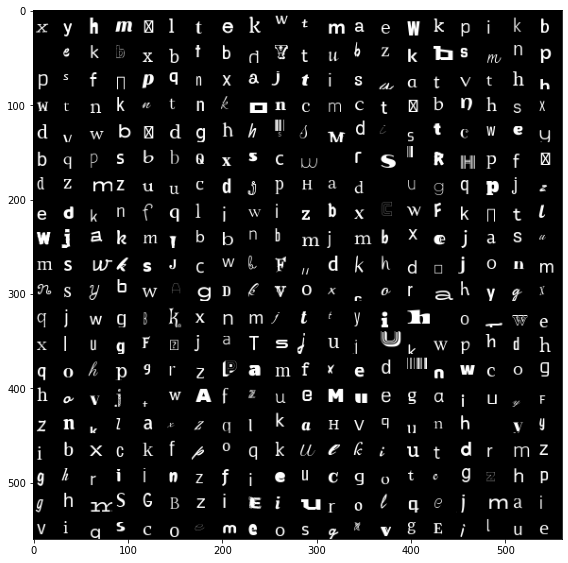

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def numpy_arrays_to_canvas(input_arr, dim=20):
  canvas = np.zeros((28*dim, 28*dim))
  for i in range(dim):
      for j in range(dim):
          image_idx = (i * dim) + j
          if image_idx < len(input_arr):
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = input_arr[image_idx].reshape(28, 28)
  return canvas

plt.figure(figsize=(8, 10))        
# Xi, Yi = np.meshgrid(x_values, y_values)
canvas = numpy_arrays_to_canvas(fonts24k.train.images)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

## Test w/ too-small array
# plt.figure(figsize=(8, 10))        
# # Xi, Yi = np.meshgrid(x_values, y_values)
# canvas = numpy_arrays_to_canvas(fonts24k.train.images[0:100])
# plt.imshow(canvas, origin="upper", cmap="gray")
# plt.tight_layout()


tuffy (26, 28, 28, 1)
gothica1 (26, 28, 28, 1)
singleday (26, 28, 28, 1)
jaldi (26, 28, 28, 1)


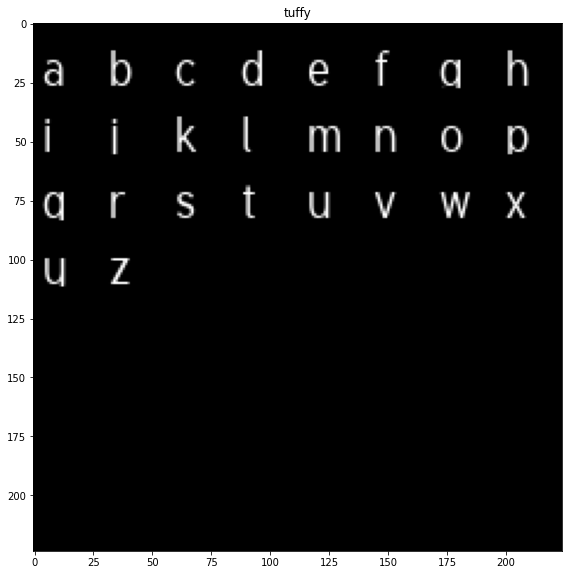

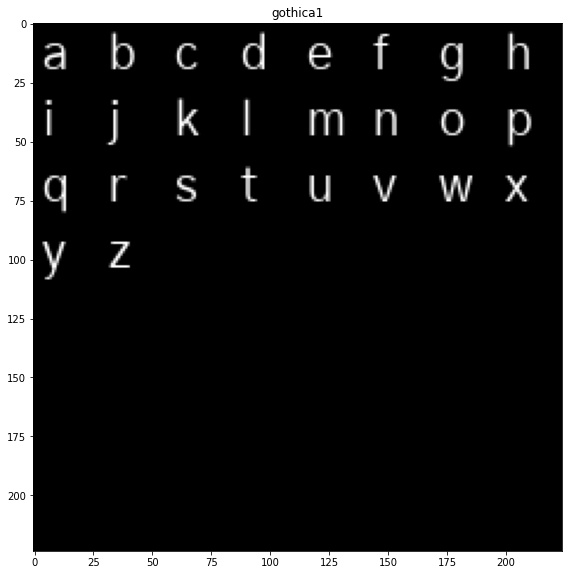

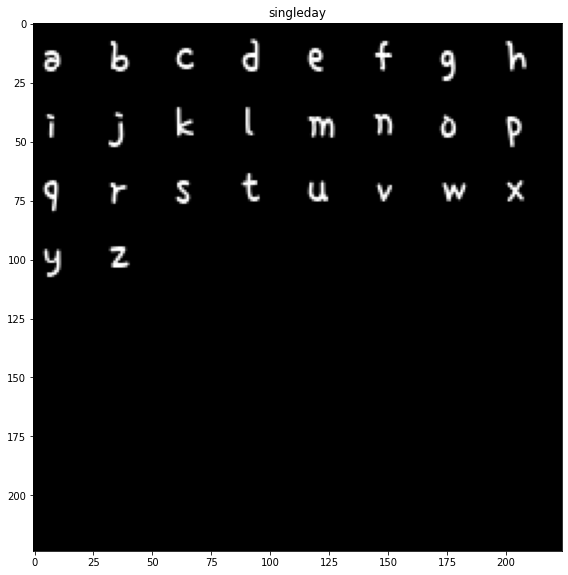

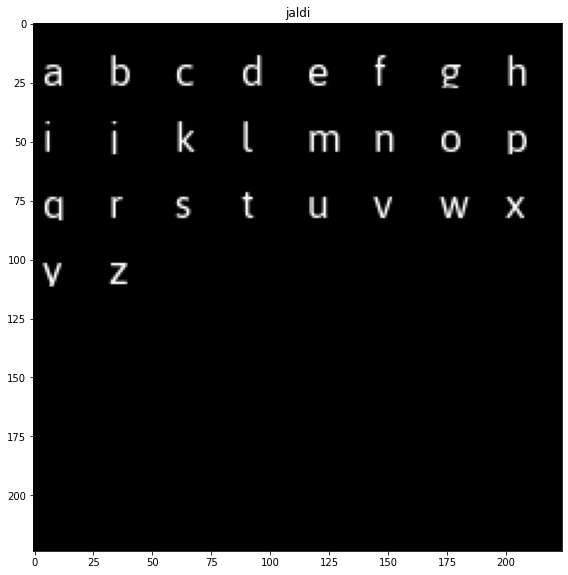

In [0]:
FONT_SAMPLES = 'samples'

for typeface_name, ttf_abs_path in read_typefaces(limit=5):
  # create_font_samples(FONT_SAMPLES, typeface_name, ttf_abs_path)
  all_arrs = []
  for char in ascii_lowercase:
    arr = np.array(Image.open(os.path.join(FONT_SAMPLES, f"{char}_{typeface_name}.png")).convert(mode='L'))
    all_arrs.append(arr)
  images = np.stack(all_arrs).reshape((len(all_arrs), 28, 28, 1))
  
  print(typeface_name, images.shape)

  plt.figure(figsize=(8, 10))        
  canvas = numpy_arrays_to_canvas(images, dim=8)
  plt.imshow(canvas, origin="upper", cmap="gray")
  plt.title(typeface_name)
  plt.tight_layout()

# Training

## Model definition

In [0]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

## Training Loop definition

In [0]:
def train(dataset, network_architecture, learning_rate=0.0001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = dataset.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

In [0]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(fonts24k, network_architecture, training_epochs=75)

Epoch: 0001 cost= 155.823980233
Epoch: 0006 cost= 91.570667268
Epoch: 0011 cost= 82.900912240
Epoch: 0016 cost= 77.806602833
Epoch: 0021 cost= 74.791204065
Epoch: 0026 cost= 72.460445868
Epoch: 0031 cost= 70.762768774
Epoch: 0036 cost= 69.259956541
Epoch: 0041 cost= 68.211426787
Epoch: 0046 cost= 67.347213517
Epoch: 0051 cost= 66.604296142
Epoch: 0056 cost= 65.748413307
Epoch: 0061 cost= 65.266490366
Epoch: 0066 cost= 64.724073100
Epoch: 0071 cost= 64.360574473


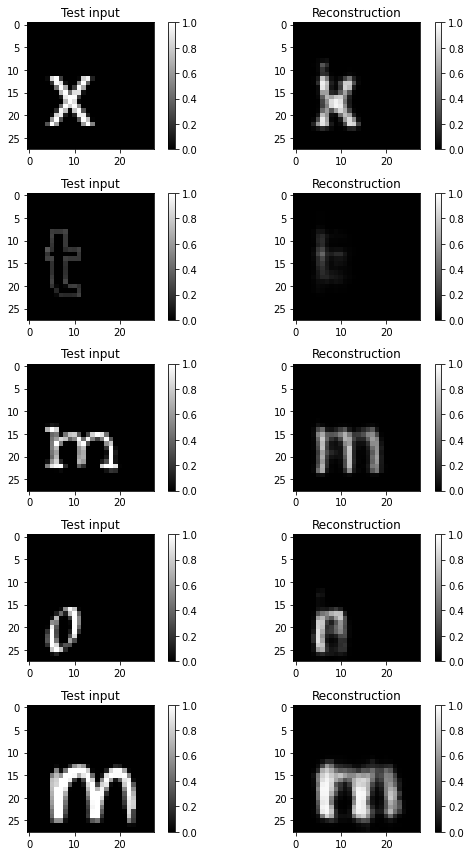

In [0]:
x_sample = fonts24k.validation.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 159.658228229
Epoch: 0006 cost= 93.723392612
Epoch: 0011 cost= 88.294210243
Epoch: 0016 cost= 87.640033890
Epoch: 0021 cost= 86.080460816
Epoch: 0026 cost= 85.482866031
Epoch: 0031 cost= 84.988145243
Epoch: 0036 cost= 84.228257298
Epoch: 0041 cost= 83.786441475
Epoch: 0046 cost= 82.833358631
Epoch: 0051 cost= 82.388836863
Epoch: 0056 cost= 82.626268800
Epoch: 0061 cost= 81.920527536
Epoch: 0066 cost= 81.975875459
Epoch: 0071 cost= 82.082115122


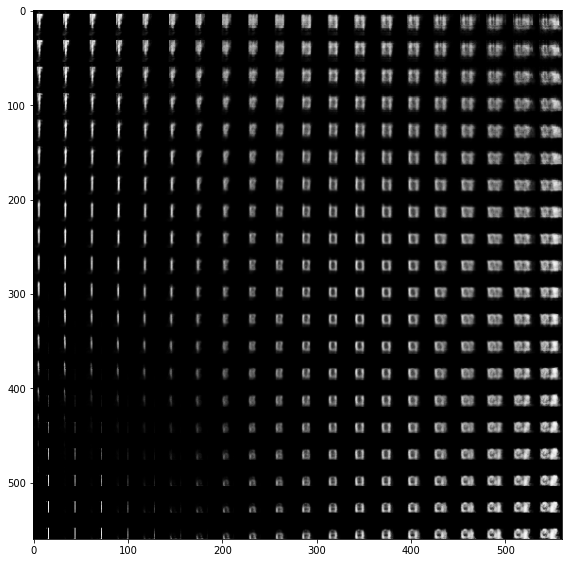

In [0]:
network_architecture_2d = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(fonts24k, network_architecture_2d, training_epochs=75)

nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

## https://github.com/FelixMohr/Deep-learning-with-Python/blob/master/VAE.ipynb

In [0]:
tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels / 2


def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

In [0]:
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd       = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

In [0]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

In [0]:
sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.


In [0]:
unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in fonts24k.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
        
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

InvalidArgumentError: ignored

## https://jmetzen.github.io/2015-11-27/vae.html

In [0]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

# np.random.seed(0)
# tf.set_random_seed(0)

In [0]:
!wget https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/mnist/input_data.py

--2020-04-06 01:51:42--  https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/mnist/input_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11743 (11K) [text/plain]
Saving to: ‘input_data.py.1’

input_data.py.1     100%[===================>]  11.47K  --.-KB/s    in 0s      

2020-04-06 01:51:42 (163 MB/s) - ‘input_data.py.1’ saved [11743/11743]



In [0]:
# !cat input_data.py
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [0]:
mnist.train.images[0].shape

(784,)

### Dataset exploration

In [0]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

### 1-D VAE

In [0]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=75)

Epoch: 0001 cost= 174.299598971
Epoch: 0006 cost= 109.592094199
Epoch: 0011 cost= 104.394794270
Epoch: 0016 cost= 101.810736875
Epoch: 0021 cost= 100.333053145
Epoch: 0026 cost= 99.316211576
Epoch: 0031 cost= 98.558843009
Epoch: 0036 cost= 97.886039554
Epoch: 0041 cost= 97.399529946
Epoch: 0046 cost= 96.919220331
Epoch: 0051 cost= 96.529553320
Epoch: 0056 cost= 96.163778118
Epoch: 0061 cost= 95.838941082
Epoch: 0066 cost= 95.589392825
Epoch: 0071 cost= 95.311474387


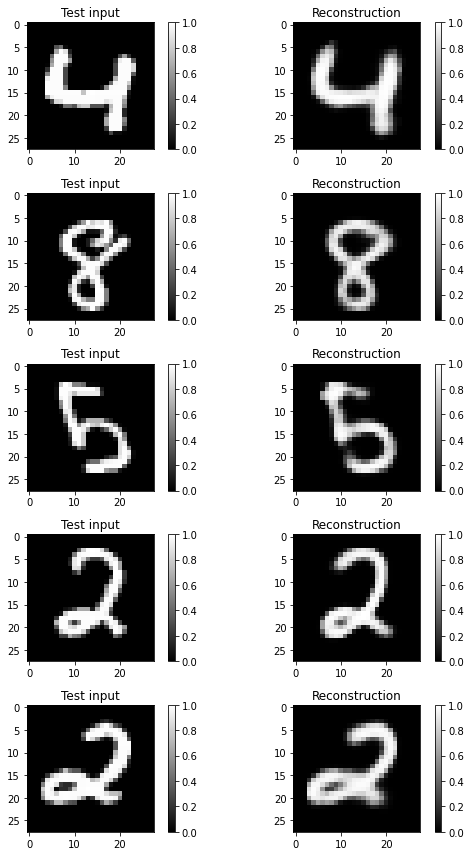

In [0]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

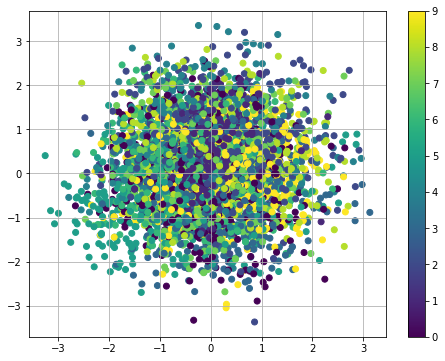

In [0]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

## 2-D VAE



In [0]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=75)

ERROR! Session/line number was not unique in database. History logging moved to new session 60


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 187.800453408
Epoch: 0006 cost= 153.417070313
Epoch: 0011 cost= 147.802381176
Epoch: 0016 cost= 145.402948775
Epoch: 0021 cost= 143.860751565
Epoch: 0026 cost= 142.675373341
Epoch: 0031 cost= 141.823526639
Epoch: 0036 cost= 141.099276692
Epoch: 0041 cost= 140.588658530
Epoch: 0046 cost= 140.111328791
Epoch: 0051 cost= 139.700456168
Epoch: 0056 cost= 139.307293008
Epoch: 0061 cost= 139.025315982
Epoch: 0066 cost= 138.699718961
Epoch: 0071 cost= 138.536931236


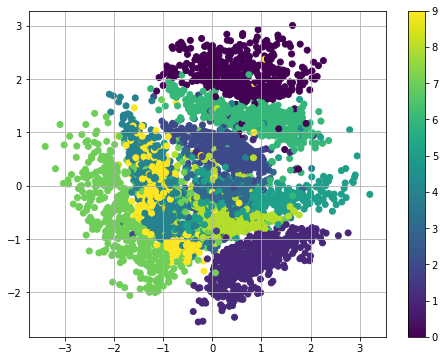

In [0]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()